In [12]:
# Import packages

# For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns


# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# For saving models
import pickle

In [3]:
df0 = pd.read_csv('xxxxxxx')

In [4]:
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     14999 non-null  float64
 1   last_evaluation        14999 non-null  float64
 2   number_project         14999 non-null  int64  
 3   average_montly_hours   14999 non-null  int64  
 4   time_spend_company     14999 non-null  int64  
 5   Work_accident          14999 non-null  int64  
 6   left                   14999 non-null  int64  
 7   promotion_last_5years  14999 non-null  int64  
 8   Department             14999 non-null  object 
 9   salary                 14999 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
df0 = df0.rename(columns={'Work_accident': 'work_accident',
                          'average_montly_hours': 'average_monthly_hours',
                          'time_spend_company': 'tenure',
                          'Department': 'department'})


In [6]:
# Since there are no missing values, we will check for duplicates

df0.duplicated().sum()
df0[df0.duplicated()].head()
df1 = df0.drop_duplicates(keep='first')
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [7]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11991 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   satisfaction_level     11991 non-null  float64
 1   last_evaluation        11991 non-null  float64
 2   number_project         11991 non-null  int64  
 3   average_monthly_hours  11991 non-null  int64  
 4   tenure                 11991 non-null  int64  
 5   work_accident          11991 non-null  int64  
 6   left                   11991 non-null  int64  
 7   promotion_last_5years  11991 non-null  int64  
 8   department             11991 non-null  object 
 9   salary                 11991 non-null  object 
dtypes: float64(2), int64(6), object(2)
memory usage: 1.0+ MB


In [20]:
def detect_outliers(df):
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    
    # Create figure and axes
    n_cols = len(numeric_cols)
    
    # Convert axes to array if single subplot
    if n_cols == 1:
        axes = [axes]
    
    outlier_summary = {}
    
    for idx, col in enumerate(numeric_cols):
        # IQR Method
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        iqr_outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col].count()
        
        # Z-score Method
        z_scores = np.abs(stats.zscore(df[col]))
        z_score_outliers = len(z_scores[z_scores > 3])

        
        # Store statistics
        col_stats = {
            'IQR_method_outliers': iqr_outliers,
            'Z_score_outliers': z_score_outliers,
            'IQR_bounds': (lower_bound, upper_bound),
            'Column_stats': {
                'mean': df[col].mean(),
                'std': df[col].std(),
                'min': df[col].min(),
                'max': df[col].max()
            }
        }
        outlier_summary[col] = col_stats
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    for col, col_stats in outlier_summary.items():
        print(f"\n{col}:")
        print(f"IQR method outliers: {col_stats['IQR_method_outliers']}")
        print(f"Z-score outliers: {col_stats['Z_score_outliers']}")
        print(f"IQR bounds: ({col_stats['IQR_bounds'][0]:.2f}, {col_stats['IQR_bounds'][1]:.2f})")
        print("\nColumn Statistics:")
        for stat_name, value in col_stats['Column_stats'].items():
            print(f"{stat_name}: {value:.2f}")
    
    return outlier_summary

outlier_summary = detect_outliers(df1)

<Figure size 640x480 with 0 Axes>


satisfaction_level:
IQR method outliers: 0
Z-score outliers: 0
IQR bounds: (-0.03, 1.33)

Column Statistics:
mean: 0.63
std: 0.24
min: 0.09
max: 1.00

last_evaluation:
IQR method outliers: 0
Z-score outliers: 0
IQR bounds: (0.13, 1.29)

Column Statistics:
mean: 0.72
std: 0.17
min: 0.36
max: 1.00

number_project:
IQR method outliers: 0
Z-score outliers: 0
IQR bounds: (0.00, 8.00)

Column Statistics:
mean: 3.80
std: 1.16
min: 2.00
max: 7.00

average_monthly_hours:
IQR method outliers: 0
Z-score outliers: 0
IQR bounds: (28.00, 372.00)

Column Statistics:
mean: 200.47
std: 48.73
min: 96.00
max: 310.00

tenure:
IQR method outliers: 824
Z-score outliers: 188
IQR bounds: (1.50, 5.50)

Column Statistics:
mean: 3.36
std: 1.33
min: 2.00
max: 10.00

work_accident:
IQR method outliers: 1850
Z-score outliers: 0
IQR bounds: (0.00, 0.00)

Column Statistics:
mean: 0.15
std: 0.36
min: 0.00
max: 1.00

left:
IQR method outliers: 1991
Z-score outliers: 0
IQR bounds: (0.00, 0.00)

Column Statistics:
mean:

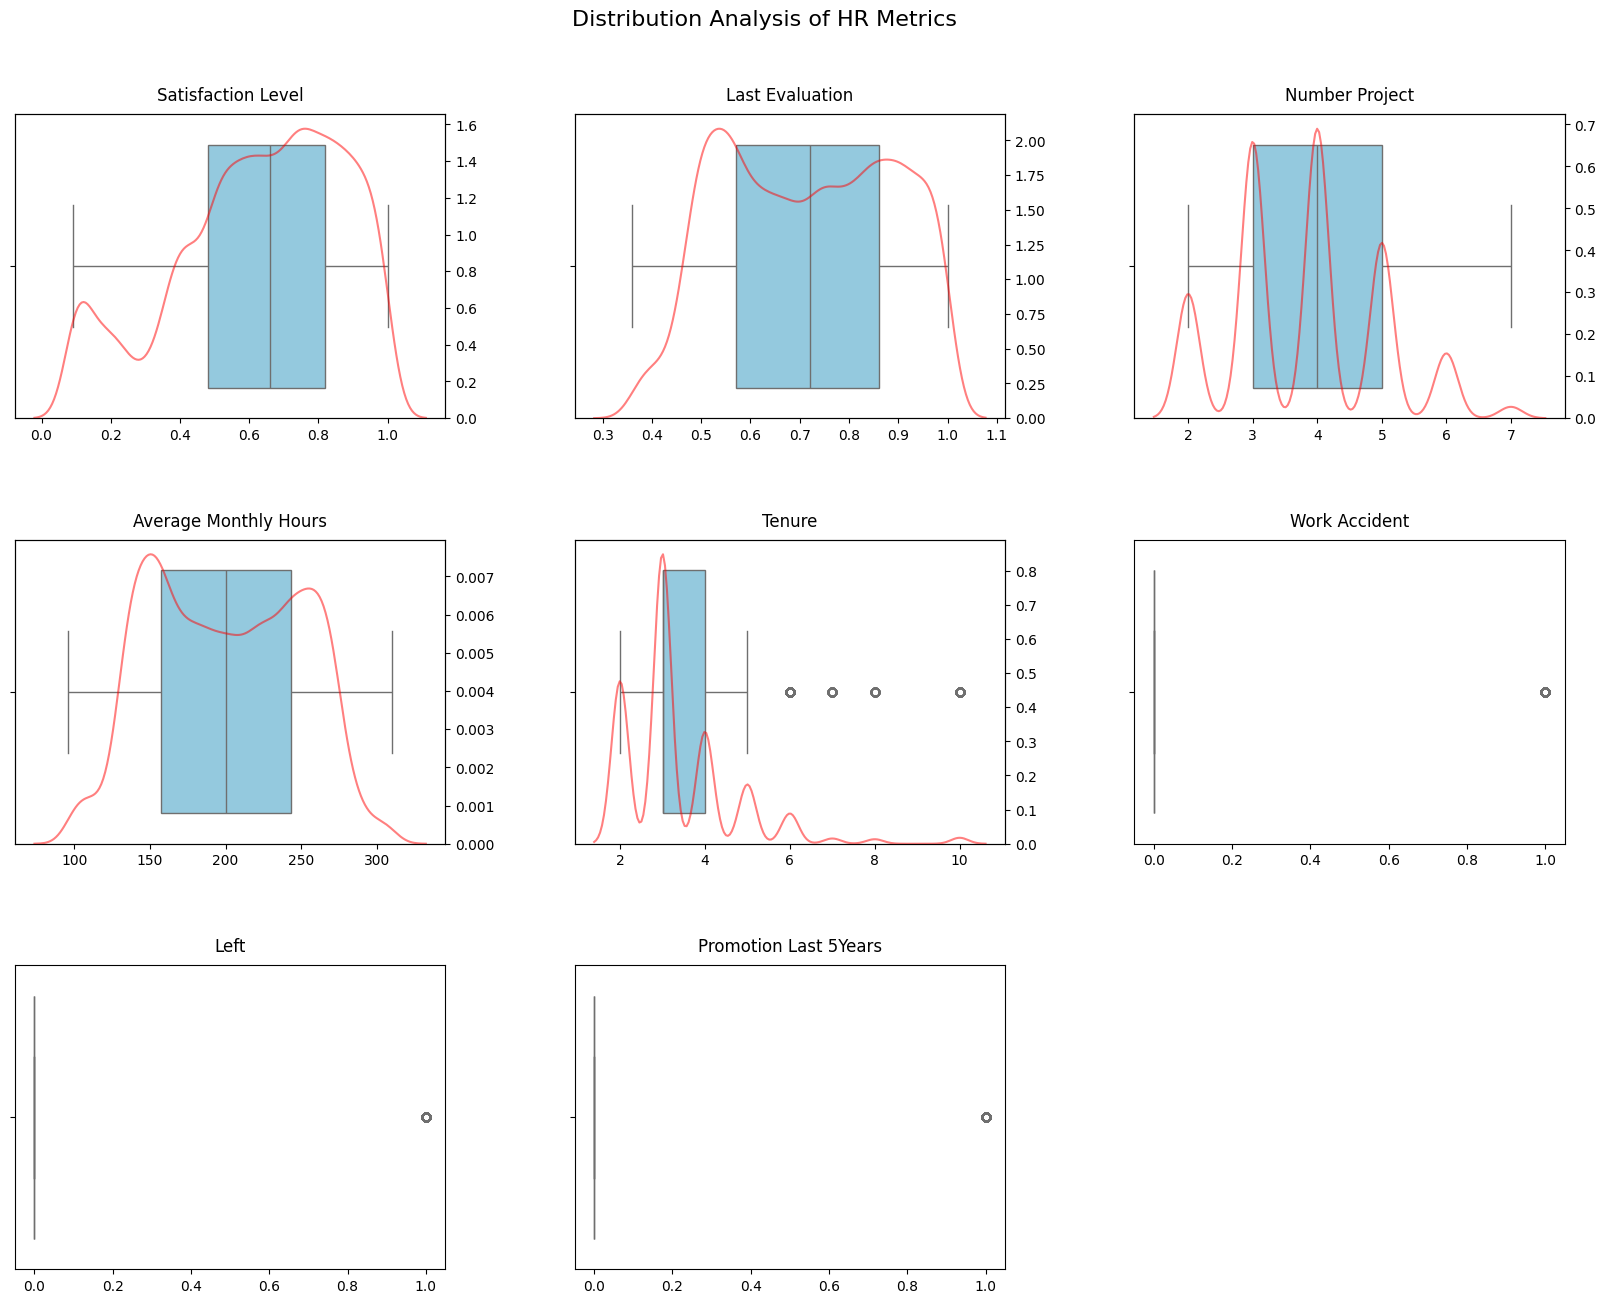

In [16]:
def plot_all_distributions(df):
    # Create figure
    fig = plt.figure(figsize=(20, 15))
    fig.suptitle('Distribution Analysis of HR Metrics', fontsize=16, y=0.95)
    
    # Create subplot grid
    gs = fig.add_gridspec(3, 3, hspace=0.4, wspace=0.3)
    
    # Columns to plot
    numeric_cols = ['satisfaction_level', 'last_evaluation', 'number_project', 
                   'average_monthly_hours', 'tenure', 'work_accident',
                   'left', 'promotion_last_5years']
    
    # Create subplots
    for idx, col in enumerate(numeric_cols):
        ax = fig.add_subplot(gs[idx // 3, idx % 3])
        
        # Create boxplot
        sns.boxplot(x=df[col], ax=ax, color='skyblue')
        ax.set_title(f'{col.replace("_", " ").title()}', pad=10)
        ax.set_xlabel('')
        
        # Add distribution curve for non-binary variables
        if col not in ['work_accident', 'left', 'promotion_last_5years']:
            ax2 = ax.twinx()
            sns.kdeplot(data=df[col], ax=ax2, color='red', alpha=0.5)
            ax2.set_ylabel('')
    
    plt.tight_layout()
    return fig

# Generate plot
fig = plot_all_distributions(df1)
plt.show()

In [21]:
# Save the cleaned dataframe to CSV
df1.to_csv('hr_analytics_cleaned.csv', index=False)